# Running the file<br>
If you wish to use your own copy of the data, use the following command:<br>
<br>
``python bike-sharing-main.py [{-i |--input=}<bike-share-csv>] [-h | --help]``<br>
<br>
Here are some examples:<br>
<br>
``python bike-sharing-main.py --input=day.csv``<br>
``python bike-sharing-main.py -i day.csv``<br>
``python bike-sharing-main.py``<br>
``python bike-sharing-main.py --help``<br>
<br>
All of these arguments are optional. Providing no arguments makes the code read from the default location, i.e. ```./data```.<br>
<br>
# Instructions on regenerating this Jupyter Notebook<br>
The Jupyter notebook can be regenerated by installing P2J, like so:<br>
<br>
``pip install p2j``<br>
<br>
and running the following:<br>
<br>
``p2j -o code/bike-sharing-main.py -t notebook/bike-sharing-assignment-notebook.ipynb``

## Library Imports

In [249]:
import getopt
import logging
import sys
import warnings

In [250]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Constants<br>
Setting up constants, so that magic strings are not repeated in the code

In [251]:
DEFAULT_DATASET_LOCATION = "../data"
DEFAULT_BIKE_SHARE_CSV_FILENAME = "day.csv"

In [252]:
class SeasonConstants:
    SEASON_1 = "spring"
    SEASON_2 = "summer"
    SEASON_3 = "fall"
    SEASON_4 = "winter"

In [253]:
class WeatherConstants:
    WEATHER_1 = "Clear, Few clouds, Partly cloudy, Partly cloudy"
    WEATHER_2 = "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist"
    WEATHER_3 = "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"
    WEATHER_4 = "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"

Setting up mapping of categorical levels to proper names to avoid confusion

In [254]:
SEASON_CATEGORICAL_MAPPING = {1: SeasonConstants.SEASON_1,
                              2: SeasonConstants.SEASON_2,
                              3: SeasonConstants.SEASON_3,
                              4: SeasonConstants.SEASON_4}

In [255]:
WEATHER_CATEGORICAL_MAPPING = {1: WeatherConstants.WEATHER_1,
                               2: WeatherConstants.WEATHER_2,
                               3: WeatherConstants.WEATHER_3,
                               4: WeatherConstants.WEATHER_4}

In [256]:
class Columns:
    WORKING_DAY = "workingday"
    HOLIDAY = "holiday"
    SEASON = "season"
    WEATHER = "weathersit"
    DATE = "dteday"
    DAY = "day"
    INSTANT = "instant"
    TEMPERATURE = 'temp'
    FEELING_TEMPERATURE = 'atemp'
    HUMIDITY = 'hum'
    WINDSPEED = 'windspeed'
    DAY_OF_WEEK = "weekday"
    MONTH = "mnth"
    CASUAL_COUNT = "casual"
    REGISTERED_COUNT = "registered"

These will be the columns that will be scaled in the training set. The same scaling will be applied to the test set.

In [257]:
COLUMNS_TO_SCALE = [Columns.TEMPERATURE, Columns.FEELING_TEMPERATURE,
                    Columns.HUMIDITY, Columns.WINDSPEED, Columns.DAY,
                    Columns.DAY_OF_WEEK, Columns.MONTH]

## Null Column Cleanup<br>
The loan dataset has several columns which are completely empty. These are useless for analysis.<br>
This function drops completely null columns.

In [258]:
def without_null_columns(bikeshares):
    heading("Null Entries Statistics")
    null_entry_statistics = bikeshares.isnull().sum() / len(bikeshares.index)
    logging.info(null_entry_statistics)
    null_columns = null_entry_statistics[null_entry_statistics == 1.0].index.to_numpy()
    heading("Completely Null Columns")
    logging.info(null_columns)
    return bikeshares.drop(null_columns, axis=1)

## Extract Day from Date

In [259]:
def with_day(bikeshares):
    dates = pd.to_datetime(bikeshares.pop(Columns.DATE), format='%d-%m-%Y')
    log_df("Dates", dates)
    bikeshares[Columns.DAY] = pd.DatetimeIndex(dates).day
    log_df("Bikeshares with Day", bikeshares, 200)
    return bikeshares

## Exploratory Data Analysis<br>
The function below performs some basic exploration of data to guide our search for relevant predictor variables. It does so by plotting correlations and heatmaps.

In [260]:
def explore(bikeshares):
    plt.figure()
    sns.pairplot(data=bikeshares)
    plt.show()
    plt.figure()
    sns.heatmap(bikeshares.corr(), cmap="YlGnBu", annot=True, annot_kws={"size": 5})
    plt.show()

## Initial Impressions<br>
- `cnt` has a definite positive correlation with `temp`, `atemp`<br>
- `cnt` has a definite positive correlation with `casual`<br>
- `cnt` has a strong positive correlation with `registered`<br>
- `cnt` has a correlation with `mnth`, but it is not linear<br>
- If it's a holiday, `cnt` seems to be lower, considering higher percentiles

## Scaling of the dataset<br>
This scaling occurs only once for the training dataset. The scaler is reused to scale the test data set.

In [261]:
def scale(bikeshares):
    test_data_scaler = MinMaxScaler()
    bikeshares[COLUMNS_TO_SCALE] = test_data_scaler.fit_transform(bikeshares[COLUMNS_TO_SCALE])
    log_df("Bikeshares after Scaling", bikeshares)
    return bikeshares, test_data_scaler

## Training the Linear Regression Model<br>
This trains the linear model using the training data set. Successively, the `atemp`, `month`, `day`, and `workingday` are dropped based on the combination of **Variance Inflation Factors** and **p-values**.

In [262]:
def train(bikeshares_x_training, bikeshares_y_training):
    lr = LinearRegression()
    lr.fit(bikeshares_x_training, bikeshares_y_training)
    bikeshares_x_training_0 = rfe_dummy(bikeshares_x_training, bikeshares_y_training, lr)
    bikeshares_x_training_0 = sm.add_constant(bikeshares_x_training_0)

    # Drop nothing in first iteration, just build model
    lm_0, bikeshares_x_training_0 = simplify_model([], bikeshares_x_training_0,
                                                   bikeshares_y_training)

    # Drop `atemp`, it has high p-value and high VIF
    lm_1, bikeshares_x_training_1 = simplify_model([Columns.FEELING_TEMPERATURE], bikeshares_x_training_0,
                                                   bikeshares_y_training)

    # Drop `month`, has high p-value and VIF~3.91
    lm_2, bikeshares_x_training_2 = simplify_model([Columns.MONTH], bikeshares_x_training_1,
                                                   bikeshares_y_training)

    # Drop `day`, has high p-value but low VIF
    lm_3, bikeshares_x_training_3 = simplify_model([Columns.DAY], bikeshares_x_training_2,
                                                   bikeshares_y_training)

    # Drop `workingday`, has high p-value > 0.005 but low VIF
    lm_4, bikeshares_x_training_4 = simplify_model([Columns.WORKING_DAY], bikeshares_x_training_3,
                                                   bikeshares_y_training)
    return lm_4, bikeshares_x_training_4

Utility function to make the dropping of columns, and retraining the model, less repetitive

In [263]:
def simplify_model(columns_to_drop, bikeshares_x_training, bikeshares_y_training):
    bikeshares_x_training_dropped = bikeshares_x_training.drop(columns_to_drop, axis=1)
    log_df("#1 Bikeshare", bikeshares_x_training_dropped)
    linear_model = sm.OLS(bikeshares_y_training, bikeshares_x_training_dropped).fit()
    summarise_model(bikeshares_x_training_dropped, linear_model)
    return linear_model, bikeshares_x_training_dropped

Utility function to summarise the model after every simplification of the Linear Model

In [264]:
def summarise_model(bikeshares_x_training, lm):
    heading("Model Summary")
    logging.info(lm.summary())
    vif_x(bikeshares_x_training)

Utility function to summarise the Variance Inflation Factors of the model after every simplification of the Linear Model

In [265]:
def vif_x(bikeshares_x_training):
    vif = pd.DataFrame()
    vif['Features'] = bikeshares_x_training.columns
    vif['VIF'] = [variance_inflation_factor(bikeshares_x_training.values, i) for i in range(
        bikeshares_x_training.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    log_df('Variance Inflation Factors', vif)

Dummy function, which will not do Recursive Factor Elimination

In [266]:
def rfe_dummy(bikeshares_x_training, bikeshares_y_training, lm):
    return bikeshares_x_training

Function, which performs Recursive Factor Elimination, if the automatic approach needs to be done in this code. Please note that the full reduction cycle of the linear model using this as the initial process, has not been tested.

In [267]:
def rfe_real(bikeshares_x_training, bikeshares_y_training, lm):
    rfe = RFE(lm, 9)  # running RFE
    rfe = rfe.fit(bikeshares_x_training, bikeshares_y_training)
    print(list(zip(bikeshares_x_training.columns, rfe.support_, rfe.ranking_)))
    relevant_columns_from_rfe = bikeshares_x_training.columns[rfe.support_]
    heading("Selected columns from RFE")
    logging.info(relevant_columns_from_rfe)
    heading("Dropped columns from RFE")
    logging.info(bikeshares_x_training.columns[~rfe.support_])
    bikeshares_x_training_rfe = bikeshares_x_training[relevant_columns_from_rfe]
    return bikeshares_x_training_rfe

In [268]:
def predict_on_test_set(scaler, lm, bikeshares_test, bikeshares_x_training_reduced_columns):
    bikeshares_y_test = bikeshares_test.pop('cnt')
    bikeshares_x_test = bikeshares_test
    bikeshares_x_test[COLUMNS_TO_SCALE] = scaler.transform(bikeshares_x_test[COLUMNS_TO_SCALE])
    bikeshares_x_test = sm.add_constant(bikeshares_x_test)
    bikeshares_x_test_reduced_columns = bikeshares_x_test[bikeshares_x_training_reduced_columns.columns]
    bikeshares_y_predictions = lm.predict(bikeshares_x_test_reduced_columns)
    fig = plt.figure()
    plt.scatter(bikeshares_y_test, bikeshares_y_predictions)
    fig.suptitle('y_test vs y_pred', fontsize=20)  # Plot heading
    plt.xlabel('y_test', fontsize=18)  # X-label
    plt.ylabel('y_pred', fontsize=16)  # Y-label
    plt.show()
    return bikeshares_y_predictions, bikeshares_y_test

## Verify Error Homoscedascity<br>
This function plots the distribution of the error terms so that we may visually inspect whether the error terms (after applying the Linear Model to the Training data set) are normally distributed.

In [269]:
def verify_error_homoscedascity(bikeshares_x_training_reduced_columns, bikeshares_y_training, lm):
    bikeshares_y_training_prediction = lm.predict(bikeshares_x_training_reduced_columns)
    fig = plt.figure()
    sns.distplot((bikeshares_y_training - bikeshares_y_training_prediction), bins=20)
    fig.suptitle('Error Terms', fontsize=20)  # Plot heading
    plt.xlabel('Errors', fontsize=18)  # X-label
    plt.show()

## Test Data / Training Data Split<br>
This function splits the master data set into the Test and Training data sets for future model evaluation.

In [270]:
def test_train_split(bikeshares_master):
    bikeshares_training, bikeshares_test = train_test_split(bikeshares_master, train_size=0.7, test_size=0.3,
                                                            random_state=100)
    heading("TEST / TRAIN SPLIT")
    logging.info(f"Training set has {len(bikeshares_training)} vectors")
    logging.info(f"Test set has {len(bikeshares_test)} vectors")
    return bikeshares_training, bikeshares_test

## Initial Data Preparation<br>
This function is responsible for dropping unneeded columns, and converting categorical variables into dummy variables.

In [271]:
def prepared(bikeshares):
    bikeshares_without_unneeded_columns = bikeshares.drop(
        [Columns.INSTANT, Columns.CASUAL_COUNT, Columns.REGISTERED_COUNT], axis=1)
    map_season = with_dummies_builder(Columns.SEASON, SEASON_CATEGORICAL_MAPPING)
    map_weather = with_dummies_builder(Columns.WEATHER, WEATHER_CATEGORICAL_MAPPING)
    return map_weather(map_season(with_day(bikeshares_without_unneeded_columns)))

In [272]:
def with_dummies_builder(categorical_column, category_mapping):
    return lambda bikeshares: with_dummy_variables(bikeshares, categorical_column, category_mapping)

This function actually performs the dummy variable setup

In [273]:
def with_dummy_variables(bikeshares, categorical_column, category_mapping):
    seasons = pd.get_dummies(bikeshares.pop(categorical_column), drop_first=True)
    log_df(f"{categorical_column} before Renaming of Dummy Variables", seasons)
    seasons = seasons.rename(columns=category_mapping)
    log_df(f"{categorical_column} after Renaming of Dummy Variables", seasons)
    bikeshares_w_dummy_seasons = pd.concat([bikeshares, seasons], axis=1)
    return bikeshares_w_dummy_seasons

## Problem-specific Utility Functions<br>
Utility function to output the final Linear Model, together with a representation of the actual linear equation

In [274]:
def output_final_model(lm):
    heading("FINAL MODEL")
    logging.info(lm.summary())
    equation = regression_equation(lm)
    heading("FINAL EQUATION")
    logging.info(equation)

Utility function to build the equation representation of the Linear Model

In [275]:
def regression_equation(lm):
    terms = lm.params.index.map(lambda index: f"({lm.params[index]} x {index})")
    equation = " + ".join(terms)
    return f"Bike Rental Demand = {equation}"

Utility function to output the R2 Score of the Linear Model as required by the problem

In [276]:
def output_r2_score(bikeshares_y_predictions, bikeshares_y_test):
    heading("R2 Score")
    logging.info(r2_score(bikeshares_y_test, bikeshares_y_predictions))

## Entry Point for the CRISP-DM process<br>
 This function is the entry point for the entire CRISPR process. This is called by `main()`

In [277]:
def study(raw_bike_share_data):
    logging.debug(raw_bike_share_data.head().to_string())
    logging.debug(raw_bike_share_data.shape)
    logging.debug(raw_bike_share_data.columns)
    bikeshares = without_null_columns(raw_bike_share_data)
    log_df("Weather 4 data point does not exist in dataset", bikeshares[bikeshares[Columns.WEATHER] == 4])
    bikeshares_master = prepared(bikeshares)
    log_df("BIKESHARES", bikeshares_master, 10)
    bikeshares_training, bikeshares_test = test_train_split(bikeshares_master)
    bikeshares_training, scaler = scale(bikeshares_training)
    explore(bikeshares_training)
    bikeshares_y_training = bikeshares_training.pop('cnt')
    bikeshares_x_training = bikeshares_training
    lm, bikeshares_x_training_reduced_columns = train(bikeshares_x_training, bikeshares_y_training)
    verify_error_homoscedascity(bikeshares_x_training_reduced_columns, bikeshares_y_training, lm)
    y_pred, y_test = predict_on_test_set(scaler, lm, bikeshares_test, bikeshares_x_training_reduced_columns)
    output_final_model(lm)

    # Including the output of the R2 Score as required by the problem
    output_r2_score(y_pred, y_test)

## Generic Application Utility Functions<br>
This function reads command line arguments, one of which can be the input loan data set

In [278]:
def parse_commandline_options(args):
    print(f"args are: {args}")
    loan_csv = f"{DEFAULT_DATASET_LOCATION}/{DEFAULT_BIKE_SHARE_CSV_FILENAME}"
    try:
        options, arguments = getopt.getopt(args, "i:hf:", ["input=", "help"])
        for option, argument in options:
            if option in ("-h", "--help"):
                print_help_text()
            elif option in ("-i", "--input"):
                loan_csv = argument
            else:
                print(f"{option} was not recognised as a valid option")
                print_help_text()
                print("Allowing to continue since Jupyter notebook passes in other command-line options")
        return loan_csv
    except getopt.GetoptError as e:
        sys.stderr.write("%s: %s\n" % (args[0], e.msg))
        print_help_text()
        exit(2)

This function prints out the help text if either explicitly requested or in case of wrong input

In [279]:
def print_help_text():
    print("USAGE: python bike-sharing-main.py [{-i |--input=}<loan-csv>]")

This function overrides Jupyter's default logger so that we can output things based on our formatting preferences

In [280]:
def setup_logging(log_level=logging.INFO):
    warnings.filterwarnings("ignore")
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logger = logging.getLogger()
    formatter = logging.Formatter('%(message)s')
    ch = logging.StreamHandler()
    ch.setLevel(log_level)
    ch.setFormatter(formatter)
    logger.setLevel(log_level)
    logger.addHandler(ch)

This function reads the loan data set

In [281]:
def read_csv(csv):
    return pd.read_csv(csv, low_memory=False)

This utility function pretty prints a heading for output

In [282]:
def heading(heading_text):
    logging.info("-" * 100)
    logging.info(heading_text)
    logging.info("-" * 100)

This utility function pretty prints a dataframe for output

In [283]:
def log_df(dataframe_label, dataframe, num_rows=10):
    heading(dataframe_label)
    logging.info(dataframe.head(num_rows).to_string())

## Main Entry Point: main()<br>
This function is the entry point of the script

In [284]:
def main():
    setup_logging()
    study(read_csv(parse_commandline_options(sys.argv[1:])))

----------------------------------------------------------------------------------------------------
Null Entries Statistics
----------------------------------------------------------------------------------------------------
instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64
----------------------------------------------------------------------------------------------------
Completely Null Columns
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------
Weather 4 data point does not exist in dataset
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
season before Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   2  3  4
0  0  0  0
1  0  0  0
2  0  0  0
3  0  0  0
4  0  0  0
5  0  0  0
6  0  0  0
7  0  0  0
8  0  0  0
9  0  0  0
----------------------------------------------------------------------------------------------------
season after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   summer  fall  winter
0       0     0       0
1       0     0       0
2       0     0       0
3       0     0       0
4       0     0       0
5       0     0       0
6       0     0       0
7       0     0       0
8       0     0       0
9       0     0       0
----------------------------------------------------------------------------------------------------
weathersit before Renaming 

args are: ['-f', '/Users/asgupta/Library/Jupyter/runtime/kernel-2d30e0d0-6950-4da7-909a-90194db0120d.json']
-f was not recognised as a valid option
USAGE: python bike-sharing-main.py [{-i |--input=}<loan-csv>]
Allowing to continue since Jupyter notebook passes in other command-line options


<Figure size 432x288 with 0 Axes>

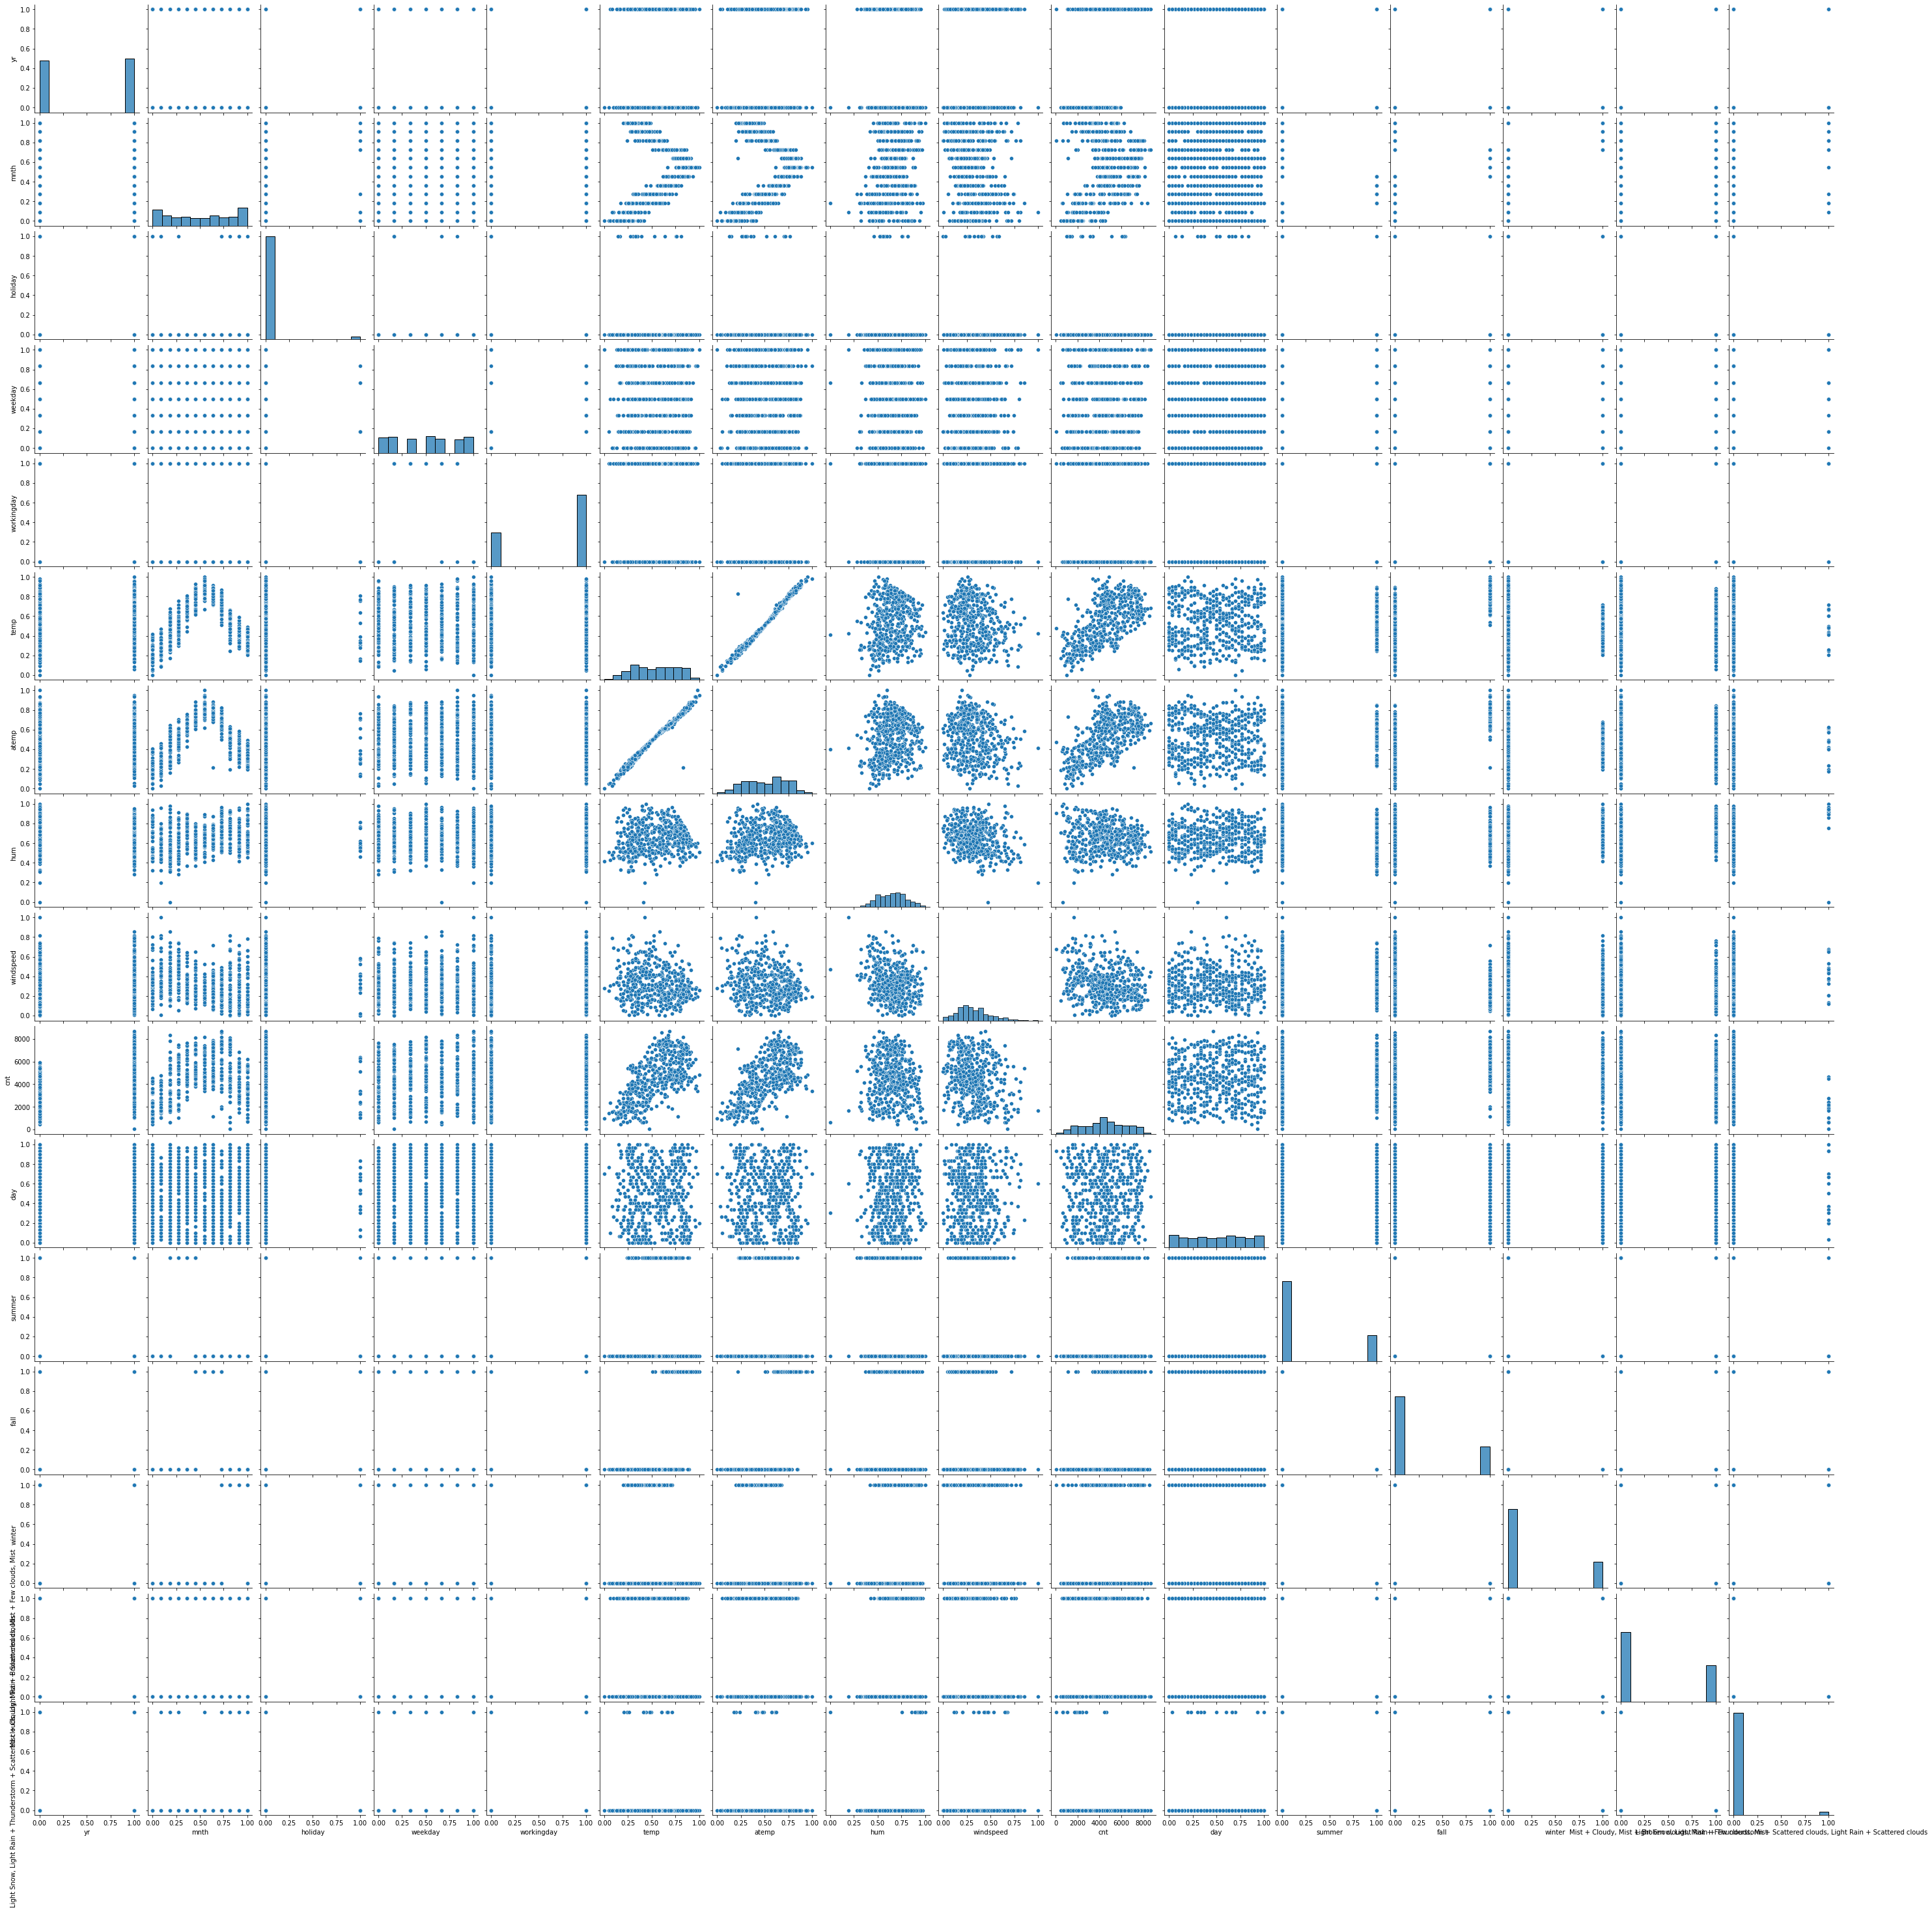

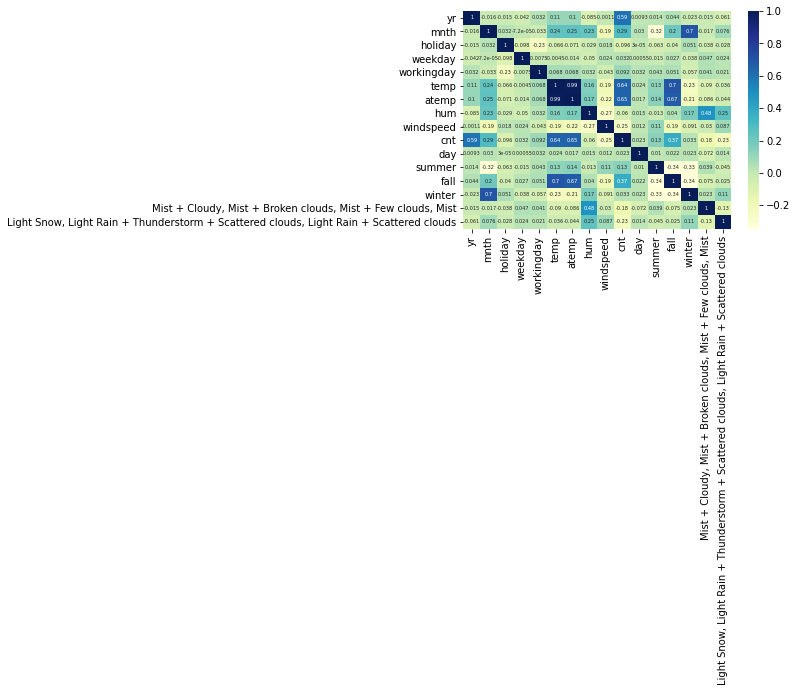

----------------------------------------------------------------------------------------------------
#1 Bikeshare
----------------------------------------------------------------------------------------------------
     const  yr      mnth  holiday   weekday  workingday      temp     atemp       hum  windspeed       day  summer  fall  winter  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
653    1.0   1  0.818182        0  0.333333           1  0.509887  0.501133  0.575354   0.300794  0.500000       0     0       1                                                             0                                                                                        0
576    1.0   1  0.545455        0  0.333333           1  0.815169  0.766351  0.725633   0.264686  1.000000       0     1       0                                                             0                                   

----------------------------------------------------------------------------------------------------
#1 Bikeshare
----------------------------------------------------------------------------------------------------
     const  yr      mnth  holiday   weekday  workingday      temp       hum  windspeed       day  summer  fall  winter  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
653    1.0   1  0.818182        0  0.333333           1  0.509887  0.575354   0.300794  0.500000       0     0       1                                                             0                                                                                        0
576    1.0   1  0.545455        0  0.333333           1  0.815169  0.725633   0.264686  1.000000       0     1       0                                                             0                                                                 

----------------------------------------------------------------------------------------------------
#1 Bikeshare
----------------------------------------------------------------------------------------------------
     const  yr  holiday   weekday  workingday      temp       hum  windspeed       day  summer  fall  winter  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
653    1.0   1        0  0.333333           1  0.509887  0.575354   0.300794  0.500000       0     0       1                                                             0                                                                                        0
576    1.0   1        0  0.333333           1  0.815169  0.725633   0.264686  1.000000       0     1       0                                                             0                                                                                        0
426  

----------------------------------------------------------------------------------------------------
#1 Bikeshare
----------------------------------------------------------------------------------------------------
     const  yr  holiday   weekday  workingday      temp       hum  windspeed  summer  fall  winter  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
653    1.0   1        0  0.333333           1  0.509887  0.575354   0.300794       0     0       1                                                             0                                                                                        0
576    1.0   1        0  0.333333           1  0.815169  0.725633   0.264686       0     1       0                                                             0                                                                                        0
426    1.0   1        0  1.000000  

----------------------------------------------------------------------------------------------------
#1 Bikeshare
----------------------------------------------------------------------------------------------------
     const  yr  holiday   weekday      temp       hum  windspeed  summer  fall  winter  Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
653    1.0   1        0  0.333333  0.509887  0.575354   0.300794       0     0       1                                                             0                                                                                        0
576    1.0   1        0  0.333333  0.815169  0.725633   0.264686       0     1       0                                                             0                                                                                        0
426    1.0   1        0  1.000000  0.442393  0.640189   0.255342       

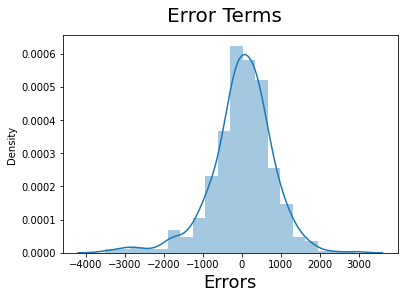

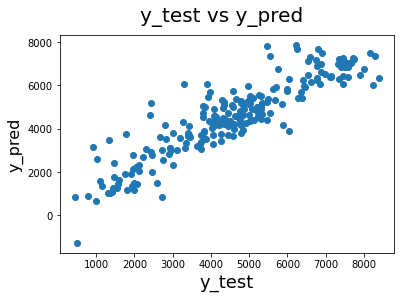

----------------------------------------------------------------------------------------------------
FINAL MODEL
----------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     224.5
Date:                Wed, 07 Jul 2021   Prob (F-statistic):          5.38e-185
Time:                        20:22:30   Log-Likelihood:                -4132.2
No. Observations:                 510   AIC:                             8288.
Df Residuals:                     498   BIC:                             8339.
Df Model:                          11                                         
Covariance Type:            nonrobust                                      

In [285]:
main()

## Conclusion<br>
The below equation summarises the linear relationship between bike rental demand and the relevant predictor variables.<br>
The selected predictors account for abput 83% of the variance in the data, as can be seen from the $R^2$ and the Adjusted $R^2$ statistics listed.

$\mathbf{rental\_bike\_demand} = 1632.382\times \mathbf{C} + 2019.478\times \mathbf{year} - 667.709\times \mathbf{holiday} + 415.293\times \mathbf{weekday} + 4298.769\times \mathbf{temperature} - 1082.769\times \mathbf{humidity} -1583.394\times \mathbf{windspeed} + 1025.765\times \mathbf{summer} + 647.160\times \mathbf{fall} + 1425.0694\times \mathbf{winter} -501.458\times \mathbf{WEATHER\_2} -2150.311\times \mathbf{WEATHER\_3}$<br>
where:<br>
**WEATHER_2** = "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)"<br>
**WEATHER_3** = "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"<br>
and the other variables are appropriately scaled.